In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3way**

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
0 / 0
0 / 0
0 / 0
0 / 1
0 / 0
2 / 1
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Model tested on 100 tasks. Accuracy: 89.87%
Confusion Matrix:
[[4 1 0]
 [0 5 0]
 [0 1 4]]
Precision: 0.9048
Recall: 0.8667
F1 Score: 0.8704
Classification Report:
                      precision    recall  f1-score   support

     Peach___healthy       1.00      0.80      0.89         5
   Soybean___healthy       0.71      1.00      0.83         5
Strawberry___healthy       1.00      0.80      0.89         5

            accuracy                           0.87        15
           macro avg       0.90      0.87      0.87        15
        weighted avg       0.90      0.87      0.87        15



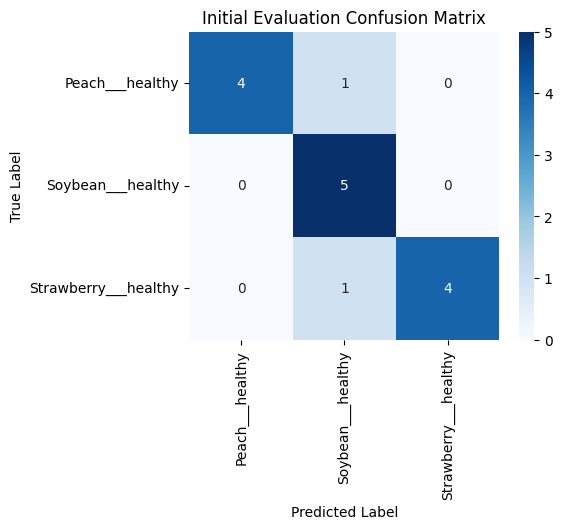

100%|██████████| 100/100 [00:27<00:00,  3.61it/s, loss=0.462]

Post-Training Evaluation:



100%|██████████| 100/100 [00:15<00:00,  6.64it/s]

Model tested on 100 tasks. Accuracy: 97.93%


In [7]:
# @title
!pip install easyfsl scikit-learn matplotlib seaborn
# Mount Google Drive


import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import densenet121
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained densenet121 model
convolutional_network = densenet121(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()


# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# Calculate metrics for the post-training evaluation
# conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
# precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
# recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
# f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
# class_report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)

# print(f"Confusion Matrix:\n{conf_matrix}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Classification Report:\n{class_report}")

# Plot confusion matrix for post-training evaluation
# plt.figure(figsize=(5, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title("Post-Training Evaluation Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# 新段落

In [10]:
import os
import shutil
import random

# 原始数据集路径
original_train_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1'
original_test_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1'

# 新的5类别数据集路径
new_train_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/train'
new_test_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/test'

# 确保新目录存在
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# 获取所有类别
all_classes = os.listdir(original_train_path)
print(f"总共有 {len(all_classes)} 个类别: {all_classes}")

# 随机选择5个类别
selected_classes = random.sample(all_classes, 5)
print(f"随机选择的5个类别: {selected_classes}")

# 复制选定的类别到新目录
for class_name in selected_classes:
    # 复制训练数据
    src_train = os.path.join(original_train_path, class_name)
    dst_train = os.path.join(new_train_path, class_name)
    if os.path.exists(src_train):
        shutil.copytree(src_train, dst_train)
        print(f"复制训练数据: {class_name}")
    else:
        print(f"警告: 训练目录 {src_train} 不存在")

    # 复制测试数据
    src_test = os.path.join(original_test_path, class_name)
    dst_test = os.path.join(new_test_path, class_name)
    if os.path.exists(src_test):
        shutil.copytree(src_test, dst_test)
        print(f"复制测试数据: {class_name}")
    else:
        print(f"警告: 测试目录 {src_test} 不存在")

print("5-way数据集创建完成！")
print(f"新训练集路径: {new_train_path}")
print(f"新测试集路径: {new_test_path}")
print(f"新数据集包含的类别: {os.listdir(new_train_path)}")

总共有 38 个类别: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato

Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]

Model tested on 100 tasks. Accuracy: 99.67%
Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                      precision    recall  f1-score   support

     Peach___healthy       1.00      1.00      1.00         5
   Soybean___healthy       1.00      1.00      1.00         5
Strawberry___healthy       1.00      1.00      1.00         5

            accuracy                           1.00        15
           macro avg       1.00      1.00      1.00        15
        weighted avg       1.00      1.00      1.00        15



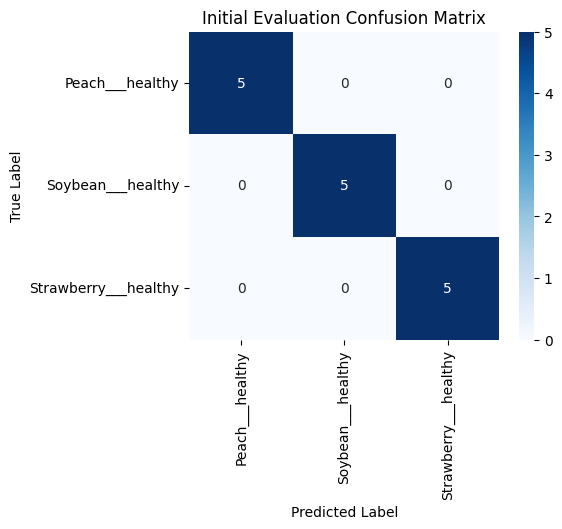

100%|██████████| 100/100 [00:35<00:00,  2.79it/s, loss=0.0319]

Post-Training Evaluation:



100%|██████████| 100/100 [00:22<00:00,  4.40it/s]

Model tested on 100 tasks. Accuracy: 99.33%


In [8]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Model tested on 100 tasks. Accuracy: 99.73%
Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                      precision    recall  f1-score   support

     Peach___healthy       1.00      1.00      1.00         5
   Soybean___healthy       1.00      1.00      1.00         5
Strawberry___healthy       1.00      1.00      1.00         5

            accuracy                           1.00        15
           macro avg       1.00      1.00      1.00        15
        weighted avg       1.00      1.00      1.00        15



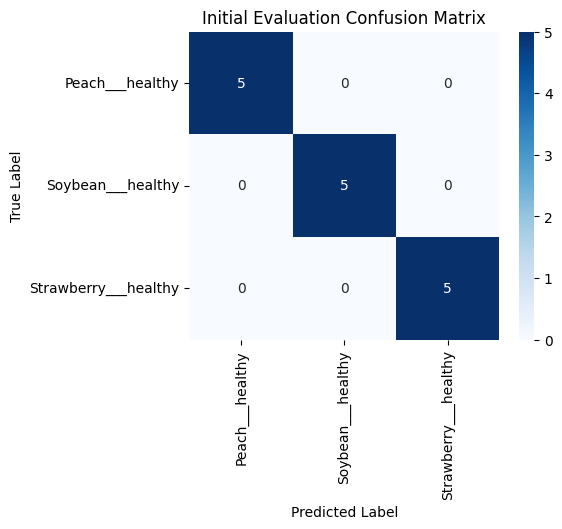

100%|██████████| 100/100 [00:50<00:00,  2.00it/s, loss=0.0254]

Post-Training Evaluation:



100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


Model tested on 100 tasks. Accuracy: 99.73%


In [9]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# 新段落

In [6]:
import os
import shutil
import random

# 原始数据集路径
original_train_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1'
original_test_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1'

# 新的3类别数据集路径
new_train_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train'
new_test_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test'

# 确保新目录存在
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# 获取所有类别
all_classes = os.listdir(original_train_path)
print(f"总共有 {len(all_classes)} 个类别: {all_classes}")

# 随机选择3个类别
selected_classes = random.sample(all_classes, 3)
print(f"随机选择的3个类别: {selected_classes}")

# 复制选定的类别到新目录
for class_name in selected_classes:
    # 复制训练数据
    src_train = os.path.join(original_train_path, class_name)
    dst_train = os.path.join(new_train_path, class_name)
    if os.path.exists(src_train):
        shutil.copytree(src_train, dst_train)
        print(f"复制训练数据: {class_name}")
    else:
        print(f"警告: 训练目录 {src_train} 不存在")

    # 复制测试数据
    src_test = os.path.join(original_test_path, class_name)
    dst_test = os.path.join(new_test_path, class_name)
    if os.path.exists(src_test):
        shutil.copytree(src_test, dst_test)
        print(f"复制测试数据: {class_name}")
    else:
        print(f"警告: 测试目录 {src_test} 不存在")

print("数据集创建完成！")
print(f"新训练集路径: {new_train_path}")
print(f"新测试集路径: {new_test_path}")
print(f"新数据集包含的类别: {os.listdir(new_train_path)}")

总共有 38 个类别: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato

In [2]:
# 1. 挂载 Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. 下载和组织数据集
import os
import zipfile
from google.colab import files

# 创建目录
target_dir = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset'
os.makedirs(target_dir, exist_ok=True)

# 下载数据集
!pip install kaggle
print("请上传 kaggle.json 文件：")
uploaded = files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
for filename in uploaded.keys():
    os.rename(filename, '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p "{target_dir}" --force

# 解压
zip_path = f"{target_dir}/plantvillage-dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print("数据集准备完成！现在可以运行你的训练代码了。")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
请上传 kaggle.json 文件：


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.01G/2.04G [00:13<00:00, 188MB/s]
100% 2.04G/2.04G [00:13<00:00, 167MB/s]
数据集准备完成！现在可以运行你的训练代码了。


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 原始数据路径（使用grayscale版本）
data_source = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/plantvillage dataset/grayscale'

# 目标路径
target_base = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset'
train_path = os.path.join(target_base, 'train')
test_path = os.path.join(target_base, 'test')

# 创建目录
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 获取所有类别
classes = os.listdir(data_source)
print(f"总类别数: {len(classes)}")

# 对每个类别进行训练集/测试集划分
for class_name in classes:
    class_path = os.path.join(data_source, class_name)
    if os.path.isdir(class_path):
        # 获取所有图片
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # 分割数据 (80% 训练, 20% 测试)
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

        # 创建类别目录
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # 复制文件
        for img in train_imgs:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_path, class_name, img))
        for img in test_imgs:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_path, class_name, img))

        print(f"{class_name}: {len(train_imgs)} 训练, {len(test_imgs)} 测试")

总类别数: 38
Apple___Apple_scab: 504 训练, 126 测试
Apple___Black_rot: 496 训练, 125 测试
Apple___Cedar_apple_rust: 220 训练, 55 测试
Apple___healthy: 1316 训练, 329 测试
Blueberry___healthy: 1201 训练, 301 测试
Cherry_(including_sour)___Powdery_mildew: 841 训练, 211 测试
Cherry_(including_sour)___healthy: 683 训练, 171 测试
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 410 训练, 103 测试
Corn_(maize)___Common_rust_: 953 训练, 239 测试
Corn_(maize)___Northern_Leaf_Blight: 788 训练, 197 测试
Corn_(maize)___healthy: 929 训练, 233 测试
Grape___Black_rot: 944 训练, 236 测试
Grape___Esca_(Black_Measles): 1106 训练, 277 测试
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 860 训练, 216 测试
Grape___healthy: 338 训练, 85 测试
Orange___Haunglongbing_(Citrus_greening): 4405 训练, 1102 测试
Peach___Bacterial_spot: 1837 训练, 460 测试
Peach___healthy: 288 训练, 72 测试
Pepper,_bell___Bacterial_spot: 797 训练, 200 测试
Pepper,_bell___healthy: 1182 训练, 296 测试
Potato___Early_blight: 800 训练, 200 测试
Potato___Late_blight: 800 训练, 200 测试
Potato___healthy: 121 训练, 31 测试
Raspberry_

# **5Way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
3 / 2
3 / 3
3 / 3
3 / 3
3 / 3
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
4 / 1
4 / 1
4 / 1
4 / 1
4 / 2
0 / 3
0 / 0
0 / 3
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Model tested on 100 tasks. Accuracy: 73.16%
Confusion Matrix:
[[3 0 0 2 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 1 4 0]
 [0 4 1 0 0]]
Precision: 0.5873
Recall: 0.6800
F1 Score: 0.6050
Classification Report:
                          precision    recall  f1-score   support

     Blueberry___healthy       1.00      0.60      0.75         5
       Grape___Black_rot       0.56      1.00      0.71         5
  Pepper,_bell___healthy       0.71      1.00      0.83         5
   Potato___Early_blight       0.67      0.80      0.73         5
Strawberry___Leaf_scorch       0.00      0.00      0.00         5

                accuracy                           0.68        25
               macro avg       0.59      0.68      0.60        25
            weighted avg       0.59      0.68      0.60        25



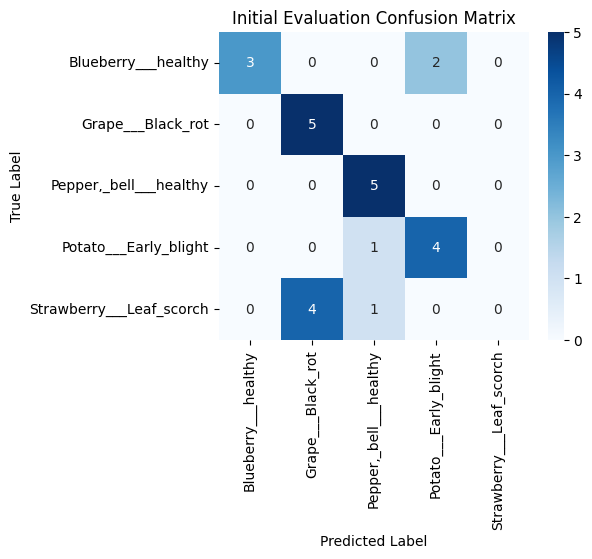

100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.456]

Post-Training Evaluation:



100%|██████████| 100/100 [00:23<00:00,  4.28it/s]

Model tested on 100 tasks. Accuracy: 97.12%


In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained densenet121 model
convolutional_network = densenet121(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
3 / 4
3 / 3
3 / 3
3 / 3
3 / 3
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


Model tested on 100 tasks. Accuracy: 99.32%
Confusion Matrix:
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 4 1]
 [0 0 0 0 5]]
Precision: 0.9667
Recall: 0.9600
F1 Score: 0.9596
Classification Report:
                          precision    recall  f1-score   support

     Blueberry___healthy       1.00      1.00      1.00         5
       Grape___Black_rot       1.00      1.00      1.00         5
  Pepper,_bell___healthy       1.00      1.00      1.00         5
   Potato___Early_blight       1.00      0.80      0.89         5
Strawberry___Leaf_scorch       0.83      1.00      0.91         5

                accuracy                           0.96        25
               macro avg       0.97      0.96      0.96        25
            weighted avg       0.97      0.96      0.96        25



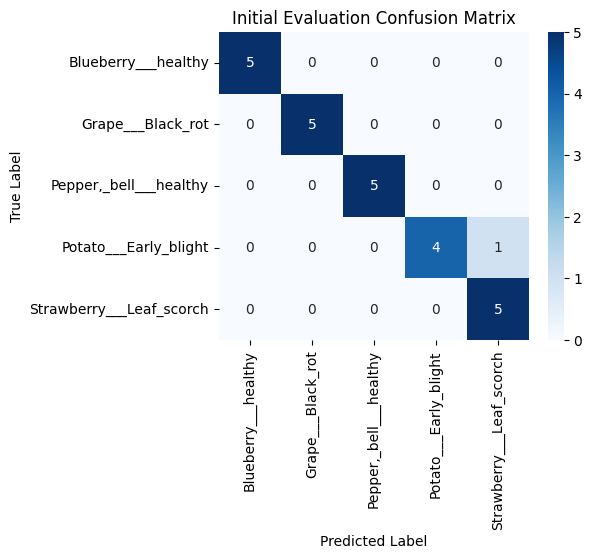

100%|██████████| 100/100 [00:54<00:00,  1.85it/s, loss=0.208]

Post-Training Evaluation:



100%|██████████| 100/100 [00:35<00:00,  2.83it/s]

Model tested on 100 tasks. Accuracy: 99.52%


In [12]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Model tested on 100 tasks. Accuracy: 99.56%
Confusion Matrix:
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                          precision    recall  f1-score   support

     Blueberry___healthy       1.00      1.00      1.00         5
       Grape___Black_rot       1.00      1.00      1.00         5
  Pepper,_bell___healthy       1.00      1.00      1.00         5
   Potato___Early_blight       1.00      1.00      1.00         5
Strawberry___Leaf_scorch       1.00      1.00      1.00         5

                accuracy                           1.00        25
               macro avg       1.00      1.00      1.00        25
            weighted avg       1.00      1.00      1.00        25



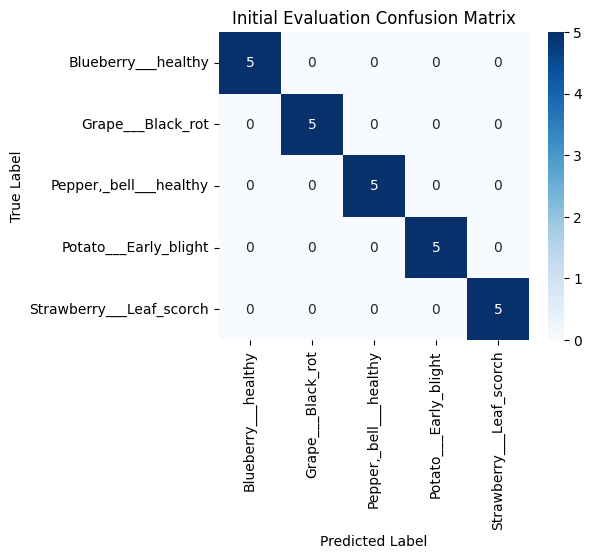

100%|██████████| 100/100 [01:19<00:00,  1.26it/s, loss=0.138]

Post-Training Evaluation:



100%|██████████| 100/100 [00:55<00:00,  1.81it/s]

Model tested on 100 tasks. Accuracy: 99.84%


In [13]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# 新段落

In [14]:
import os
import shutil

# 原始数据集路径
original_train_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1'
original_test_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1'

# 新的10类别数据集路径
new_train_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/train'
new_test_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/test'

# 确保新目录存在
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# 手动指定10个类别（根据你的实际需求修改）
selected_classes = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry___healthy',
    'Cherry___Powdery_mildew',
    'Corn___healthy',
    'Corn___Northern_Leaf_Blight',
    'Grape___Black_rot'
    # 替换为实际的10个类别名称
]

print(f"选择的10个类别: {selected_classes}")

# 复制选定的类别到新目录
for class_name in selected_classes:
    # 复制训练数据
    src_train = os.path.join(original_train_path, class_name)
    dst_train = os.path.join(new_train_path, class_name)
    if os.path.exists(src_train):
        shutil.copytree(src_train, dst_train)
        print(f"复制训练数据: {class_name}")
    else:
        print(f"警告: 训练目录 {src_train} 不存在")

    # 复制测试数据
    src_test = os.path.join(original_test_path, class_name)
    dst_test = os.path.join(new_test_path, class_name)
    if os.path.exists(src_test):
        shutil.copytree(src_test, dst_test)
        print(f"复制测试数据: {class_name}")
    else:
        print(f"警告: 测试目录 {src_test} 不存在")

print("10-way数据集创建完成！")
print(f"新训练集路径: {new_train_path}")
print(f"新测试集路径: {new_test_path}")
print(f"新数据集包含的类别: {os.listdir(new_train_path)}")

选择的10个类别: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot']
复制训练数据: Apple___Apple_scab
复制测试数据: Apple___Apple_scab
复制训练数据: Apple___Black_rot
复制测试数据: Apple___Black_rot
复制训练数据: Apple___Cedar_apple_rust
复制测试数据: Apple___Cedar_apple_rust
复制训练数据: Apple___healthy
复制测试数据: Apple___healthy
复制训练数据: Blueberry___healthy
复制测试数据: Blueberry___healthy
警告: 训练目录 /content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1/Cherry___healthy 不存在
警告: 测试目录 /content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1/Cherry___healthy 不存在
警告: 训练目录 /content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1/Cherry___Powdery_mildew 不存在
警告: 测试目录 /content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1/Cherry___Powdery_mildew 不存在
警告: 训练目录 /content/drive/MyDrive/plantvillage-all-3way/plant

In [15]:
import os
import shutil
import random

# 原始数据集路径
original_train_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train1'
original_test_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test1'

# 新的10类别数据集路径
new_train_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/train'
new_test_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/test'

# 确保新目录存在
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# 获取所有类别
all_classes = os.listdir(original_train_path)
print(f"总共有 {len(all_classes)} 个类别: {all_classes}")

# 随机选择10个类别
selected_classes = random.sample(all_classes, 10)
print(f"随机选择的10个类别: {selected_classes}")

# 复制选定的类别到新目录
for class_name in selected_classes:
    # 复制训练数据
    src_train = os.path.join(original_train_path, class_name)
    dst_train = os.path.join(new_train_path, class_name)
    if os.path.exists(src_train):
        shutil.copytree(src_train, dst_train)
        print(f"复制训练数据: {class_name}")
    else:
        print(f"警告: 训练目录 {src_train} 不存在")

    # 复制测试数据
    src_test = os.path.join(original_test_path, class_name)
    dst_test = os.path.join(new_test_path, class_name)
    if os.path.exists(src_test):
        shutil.copytree(src_test, dst_test)
        print(f"复制测试数据: {class_name}")
    else:
        print(f"警告: 测试目录 {src_test} 不存在")

print("10-way数据集创建完成！")
print(f"新训练集路径: {new_train_path}")
print(f"新测试集路径: {new_test_path}")
print(f"新数据集包含的类别: {os.listdir(new_train_path)}")

总共有 38 个类别: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato

# **10way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
2 / 2
2 / 0
2 / 2
2 / 2
2 / 0
0 / 0
0 / 0
0 / 7
0 / 9
0 / 0
5 / 5
5 / 5
5 / 5
5 / 1
5 / 9
3 / 8
3 / 9
3 / 8
3 / 9
3 / 8
1 / 9
1 / 1
1 / 8
1 / 9
1 / 1
6 / 9
6 / 6
6 / 7
6 / 9
6 / 6
8 / 5
8 / 8
8 / 9
8 / 9
8 / 9
7 / 9
7 / 7
7 / 0
7 / 9
7 / 9
4 / 4
4 / 4
4 / 4
4 / 8
4 / 4


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Model tested on 100 tasks. Accuracy: 47.42%
Confusion Matrix:
[[3 0 0 0 0 0 0 1 0 1]
 [0 2 0 0 0 0 0 0 1 2]
 [2 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 2]
 [0 0 0 0 4 0 0 0 1 0]
 [0 1 0 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 2 1 0 2]
 [1 0 0 0 0 0 0 1 0 3]
 [0 0 0 0 0 1 0 0 1 3]
 [0 0 0 0 0 0 0 0 0 5]]
Precision: 0.5680
Recall: 0.4800
F1 Score: 0.4771
Classification Report:
                                          precision    recall  f1-score   support

                Apple___Cedar_apple_rust       0.50      0.60      0.55         5
Cherry_(including_sour)___Powdery_mildew       0.67      0.40      0.50         5
       Cherry_(including_sour)___healthy       1.00      0.60      0.75         5
                  Peach___Bacterial_spot       0.00      0.00      0.00         5
                       Soybean___healthy       1.00      0.80      0.89         5
                    Strawberry___healthy       0.75      0.60      0.67         5
                    Tomato___Late_blight       1.00      0.

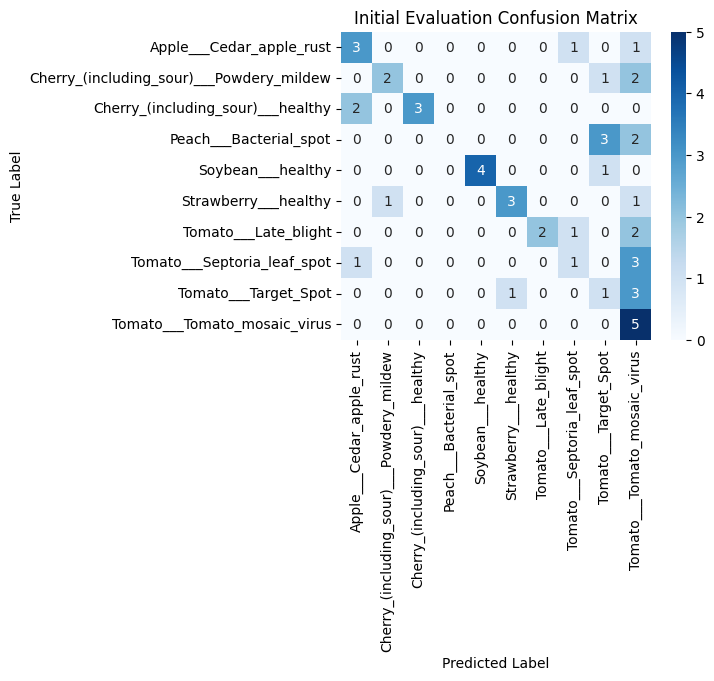

100%|██████████| 100/100 [01:07<00:00,  1.49it/s, loss=1.55]

Post-Training Evaluation:



100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Model tested on 100 tasks. Accuracy: 78.58%


In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained densenet121 model
convolutional_network = densenet121(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
4 / 4
4 / 4
4 / 6
4 / 4
4 / 4
7 / 0
7 / 7
7 / 7
7 / 7
7 / 7
9 / 1
9 / 9
9 / 9
9 / 6
9 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
1 / 1
1 / 1
1 / 1
1 / 1
1 / 4
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
5 / 5
5 / 5
5 / 5
5 / 5
5 / 5
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Model tested on 100 tasks. Accuracy: 88.34%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 1 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [1 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [1 1 0 0 0 0 1 0 0 2]]
Precision: 0.9029
Recall: 0.8800
F1 Score: 0.8727
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       0.71      1.00      0.83         5
           (Botryosphaeria obtusa)Apple_Black_rot       0.80      0.80      0.80         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
            (Guignardia bidwellii)Grape_Black_rot       0.80      0.80      0.80         5
                (Isariopsis spp)Grape_Leaf_blight       1.00      1.00      1.00       

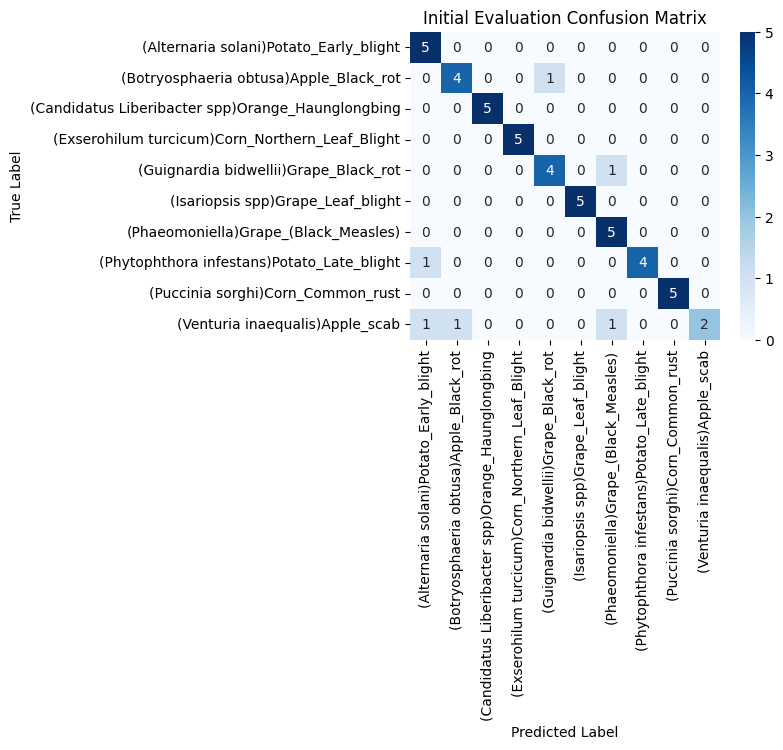

100%|██████████| 100/100 [01:47<00:00,  1.07s/it, loss=0.221]

Post-Training Evaluation:



100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Model tested on 100 tasks. Accuracy: 84.92%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)